In [1]:
# %load_ext autoreload # uncomment this line if you want to reload modules automatically
# %autoreload 2 # uncomment this line if you want to reload modules automatically

import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from ipywidgets import interact
from skimage.measure import label
import scipy.stats as stats
from matplotlib.patches import Rectangle, Circle, Ellipse
import matplotlib.dates as mdates
import pandas as pd
from astropy.io import fits
import scipy.signal as signal
import json

from scripts.imagedata import ImageData
from scripts.neutralliner import NeutralLiner
from scripts.msenet import MSENet
from scripts.config import device, PATH_TO_MCINTOSH

#### Display fits

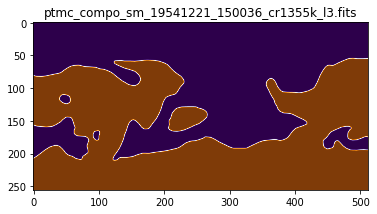

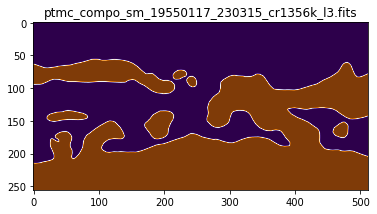

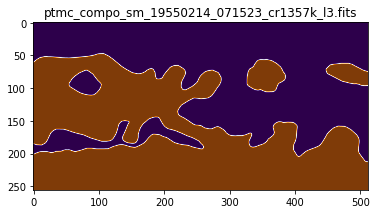

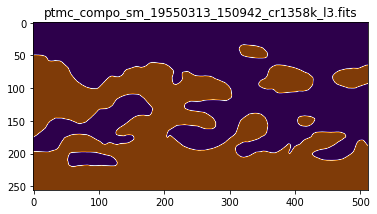

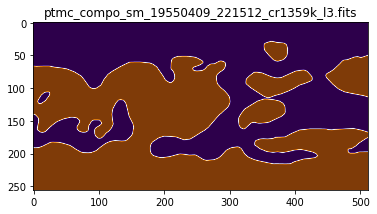

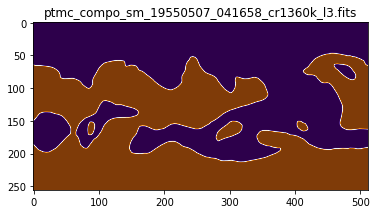

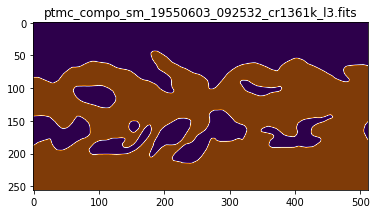

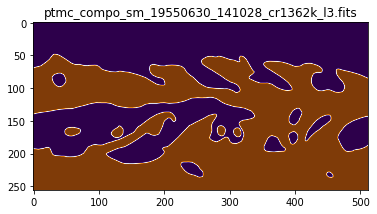

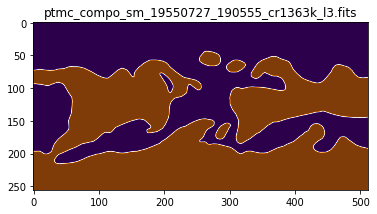

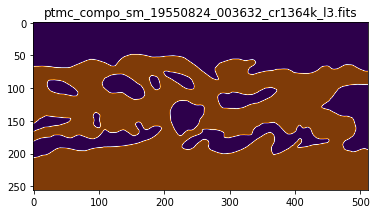

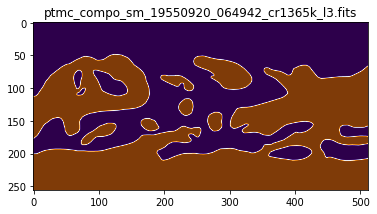

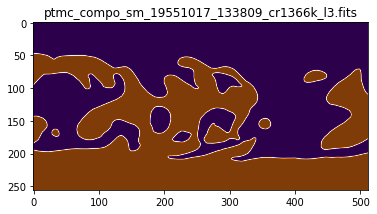

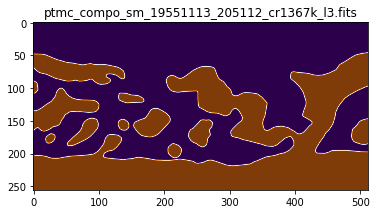

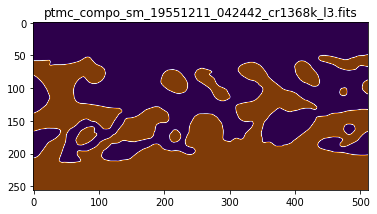

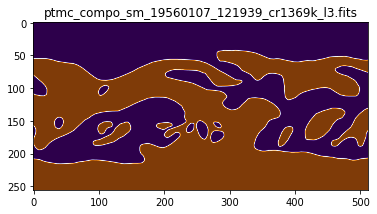

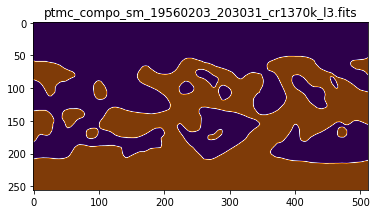

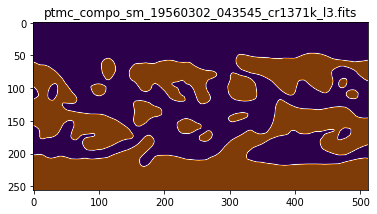

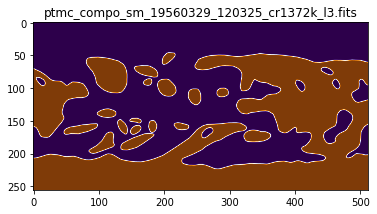

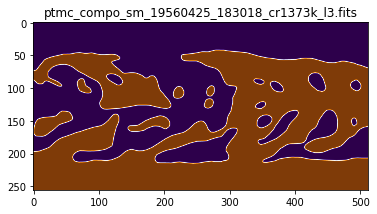

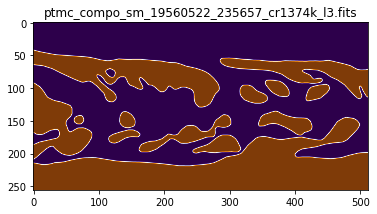

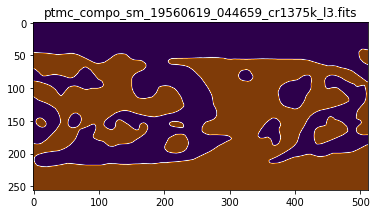

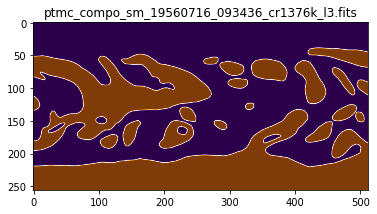

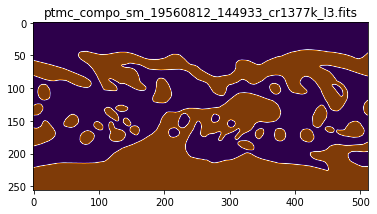

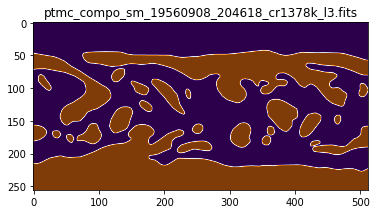

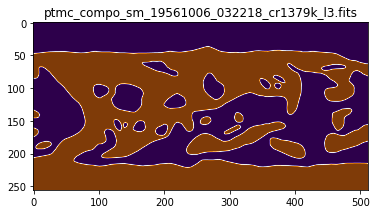

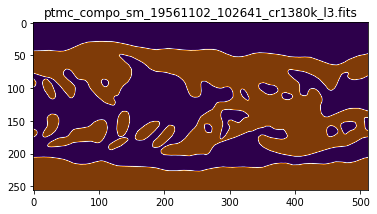

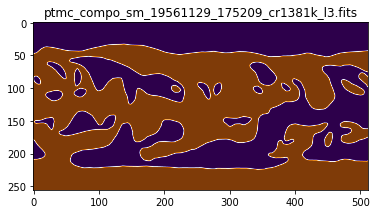

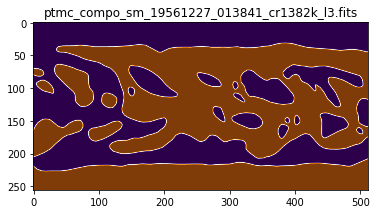

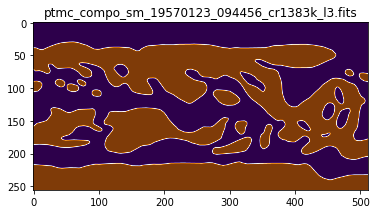

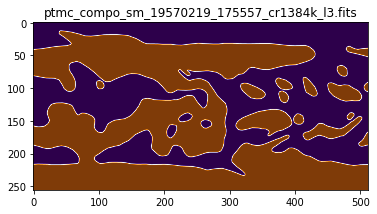

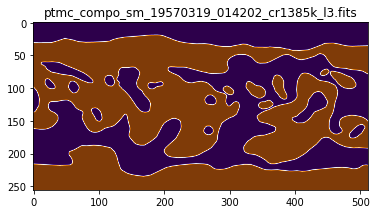

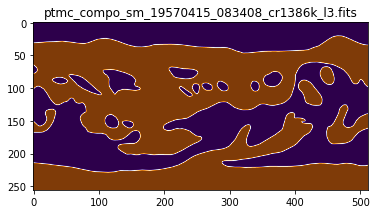

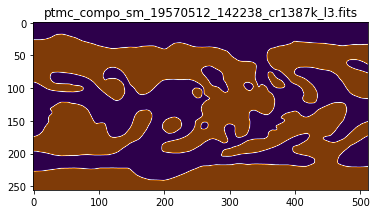

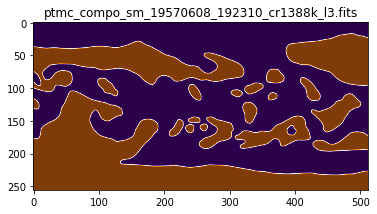

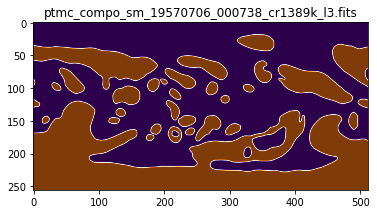

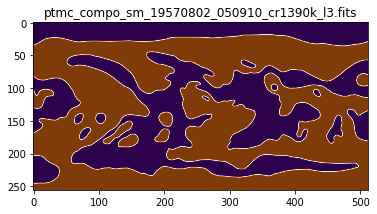

In [5]:
for filename in os.listdir(PATH_TO_MCINTOSH)[:36]:
    imgdata = ImageData(os.path.join(PATH_TO_MCINTOSH, filename), 'fits')
    plt.imshow(imgdata.target_img, cmap='PuOr')
    plt.title(filename)
    plt.show()

In [3]:
@interact(filename=os.listdir(PATH_TO_MCINTOSH))
def show_image(filename):
    img_data = ImageData(os.path.join(PATH_TO_MCINTOSH, filename), 'fits')
    img_data.show_image()
    plt.figure(figsize=(10, 5))
    plt.imshow(img_data.target_img, cmap='PuOr')
    plt.title('Target image')
    plt.show()

interactive(children=(Dropdown(description='filename', options=('ptmc_compo_sm_19541221_150036_cr1355k_l3.fits…

# No pretrain

In [ ]:
filenames = os.listdir(PATH_TO_MCINTOSH)[:28]

num_epochs = 10000
arch = [3, 6, 12, 24, 12, 6, 3, 1]
lr = 1e-3
weight_decay = 1e-4

for filename in filenames:
    model = NeutralLiner(image_list=[ImageData(path_or_img=os.path.join(PATH_TO_MCINTOSH, filename), data_mode='fits')],
                lr=lr, arch=arch, mode='3d', weight_decay=weight_decay)
    model.to(device)
    model.start_training(num_epochs=num_epochs, need_plot=True, need_save=False)

# Pretrain with MSENet on first 28 maps

## Pretrain

In [ ]:
filenames = os.listdir(PATH_TO_MCINTOSH)[:28]
n_tryes = 5
num_epochs = 30000
arch = [3, 6, 12, 24, 12, 6, 3, 1]
lr = 1e-3
weight_decay = 1e-4

path_to_save = 'Tests/Fits/MSEnet/'
os.makedirs(path_to_save, exist_ok=True)

In [ ]:
for i, filename in enumerate(filenames):
    print(f'Map {i+1}/{len(filenames)}')
    for j in range(n_tryes):
        print(f'Try {j+1}/4')
        imgdata = ImageData(path_or_img=os.path.join(PATH_TO_MCINTOSH, filename), data_mode='fits')
        imgdata.img_array = imgdata.target_img
        msenet = MSENet(img=imgdata, arch=arch, mode='3d')
        msenet.to(device)
        msenet.train(num_epochs=num_epochs,
                     need_plot=False,
                     lr=lr,
                     weight_decay=weight_decay)
        torch.save(msenet.state_dict(), path_to_save + f'model_{i}_try_{j}.pt')
        prediction = msenet(imgdata.data_3d.to(device)).cpu().detach().view(256, 512).numpy()
        plt.figure(figsize=(20, 6))
        plt.suptitle(f'File: {filename}\narch: {arch}\nloss: {msenet.loss_dict[-1]:.4f}\nnum_epochs: {num_epochs}, lr: {lr}, weight_decay: {weight_decay}, Try: {j}')
        plt.subplot(1, 2, 1)
        plt.imshow(imgdata.target_img, cmap='PuOr')
        plt.title('Target')
        plt.subplot(1, 2, 2)
        plt.imshow(prediction, cmap='PuOr')
        plt.title('Prediction')
        plt.savefig(path_to_save + f'img_{i}_try_{j}.png', bbox_inches='tight', pad_inches=0, facecolor='white')


## Use pretrained weights

In [ ]:
path_to_pretrained_weights = './state_dict/fits/first28/'
filenames = os.listdir(PATH_TO_MCINTOSH)[1:28]
weights = os.listdir(path_to_pretrained_weights)[:-1]

num_epochs = 5
arch = [3, 6, 12, 24, 12, 6, 3, 1]
lr = 1e-2
weight_decay = 1e-3

os.makedirs(path_to_save, exist_ok=True)


In [ ]:
i=1
for path_to_weight, filename in tqdm(zip(weights, filenames)):
    model = NeutralLiner(image_list=[ImageData(path_or_img=os.path.join(PATH_TO_MCINTOSH, filename), data_mode='fits')],
                lr=lr, arch=arch, mode='3d', weight_decay=weight_decay)
    model.to(device)
    model.load_state_dict(torch.load(os.path.join(path_to_pretrained_weights, path_to_weight)))
    start_state = model.test_model()[0]

    model.start_training(num_epochs=num_epochs,
                need_plot=True,
                need_save=False)
    model.save_state_dict(path_to_save + f'model_{i}.pt')
    plt.figure(figsize=(20, 10))
    plt.subplot(2, 2, 1)
    plt.imshow(model.image_list[0].img_array, cmap='PuOr', vmin=-1, vmax=1)
    plt.title('Input image with filaments')
    plt.subplot(2, 2, 2)
    plt.imshow(model.image_list[0].target_img, cmap='PuOr')
    plt.title('Target image')
    plt.subplot(2, 2, 3)
    plt.imshow(start_state.view(256, 512), cmap='PuOr')
    plt.title('Start state')
    plt.subplot(2, 2, 4)
    plt.imshow(model.test_model()[0].view(256, 512), cmap='PuOr')
    plt.title('Prediction')
    plt.tight_layout()
    plt.savefig(path_to_save + f'model_{i}', bbox_inches='tight', pad_inches=0, facecolor='white')
    i+=1


# Semi-supervised learning

Help info vizualization

In [5]:
imgdata = ImageData(os.path.join(PATH_TO_MCINTOSH, os.listdir(PATH_TO_MCINTOSH)[0]), data_mode='fits')
@interact(x=(1, 255, 1))
def f(x=127):
    y= imgdata.target_img.copy()
    y[20:-20, :][::x, ::x] = -0.5
    plt.figure(figsize=(10, 5))
    plt.imshow(y, cmap='PuOr')
    plt.show()

interactive(children=(IntSlider(value=127, description='x', max=255, min=1), Output()), _dom_classes=('widget-…

In [ ]:
for mapname in os.listdir(PATH_TO_MCINTOSH)[:10]:
    img = ImageData(path_or_img=os.path.join(PATH_TO_MCINTOSH, mapname), data_mode='fits').target_img
    hsz_img = img[20:-20, :][::help_step_size, ::help_step_size]
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='PuOr')
    plt.title(f'Target for {mapname}')
    plt.subplot(1, 2, 2)
    plt.imshow(hsz_img, cmap='PuOr')
    plt.title('help_step_size = 31')
    plt.savefig(f'{mapname}.png', bbox_inches='tight', pad_inches=0, facecolor='white')

## Single runs

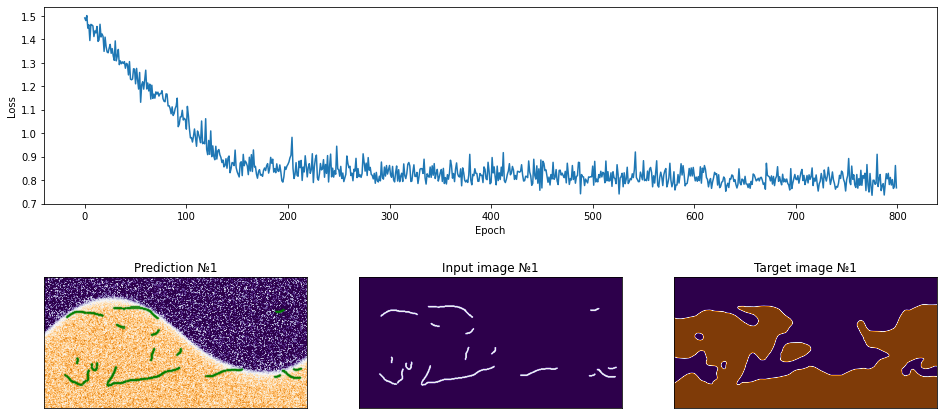

KeyboardInterrupt: 

In [2]:
model = NeutralLiner(image_list=[ImageData(os.path.join(PATH_TO_MCINTOSH, os.listdir(PATH_TO_MCINTOSH)[0]), data_mode='fits')],
                     lr=1e-3,
                     help_step_size=None,
                     mode='3d',
                     arch=[3, 6, 12, 24, 12, 6, 3, 1],
                     weight_decay=1e-3)
model.to(device)
model.start_training(num_epochs=10000, need_plot=True, my_weight=0)

In [ ]:
model.test_model()

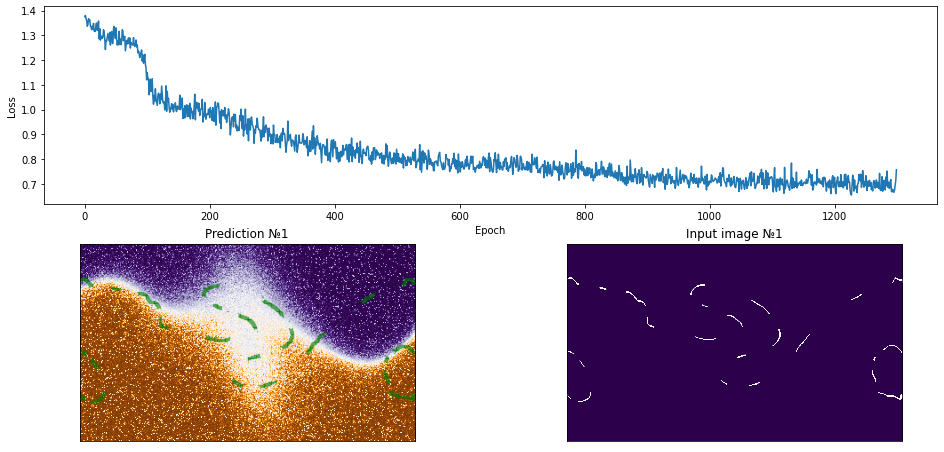

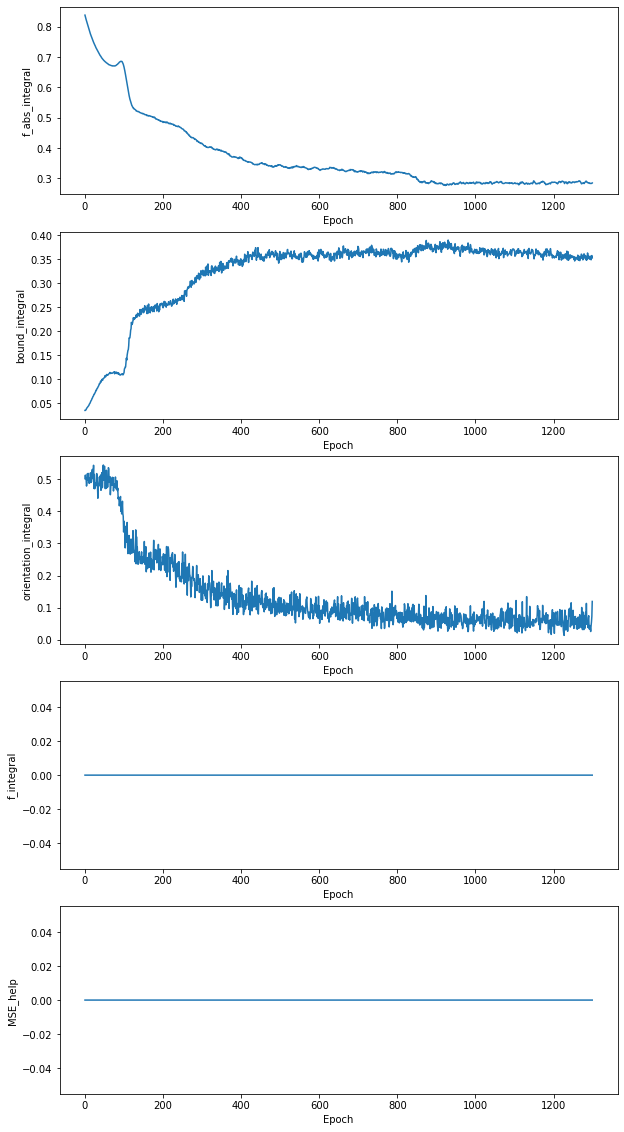

KeyboardInterrupt: 

In [3]:
model = NeutralLiner(image_list=[ImageData('./imgs/2_r.png', data_mode='path')],
                     lr=1e-3,
                     help_step_size=None,
                     mode='3d',
                     arch=[3, 6, 12, 24, 12, 6, 3, 1],
                     weight_decay=1e-3)
model.to(device)
model.start_training(num_epochs=5000, need_plot=True, my_weight=0)
# model.test_model(full_path_to_save='./test.png', need_plot=True)


## 10 runs per first 10 maps

### step 1 (full info)

In [ ]:
filenames = os.listdir(PATH_TO_MCINTOSH)[:10]
path_to_save = './Tests/Fits/Mean/step1/'
os.makedirs(path_to_save, exist_ok=True)

for i, filename in enumerate(filenames):
    predictions = []
    for n in tqdm(range(10), desc=f'Predicting map {i+1}/{len(filenames)}'):
        imgdata = ImageData(os.path.join(PATH_TO_MCINTOSH, filename), data_mode='fits')
        model = NeutralLiner(image_list=[imgdata],
                            lr=5e-3,
                            help_step_size=1,
                            mode='3d',
                            arch=[3, 6, 12, 24, 12, 6, 3, 1],
                            weight_decay=1e-4)
        model.to(device)
        model.start_training(num_epochs=30000, need_plot=False)
        prediction = model.test_model(need_plot=False,
                                      full_path_to_save=os.path.join(path_to_save, f'map_{i:02d}_{n}')
                                      )[0].view(model.image_list[0].img_array.shape).cpu().detach()
        predictions.append(prediction)
        model.save_state_dict(os.path.join(path_to_save, f'map_{i:02d}_{n}.pt'))
    predictions = torch.stack(predictions)
    prediction = torch.mean(predictions, dim=0)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(imgdata.target_img, cmap='PuOr')
    plt.title(f'Target for map {i}')
    plt.subplot(1, 2, 2)
    plt.imshow(prediction, cmap='PuOr')
    plt.title(f'Mean prediction for map {i}')
    plt.savefig(os.path.join(path_to_save, f'map_{i:02d}_mean.png'), bbox_inches='tight', pad_inches=0, facecolor='white')

### step 32

In [ ]:
filenames = os.listdir(PATH_TO_MCINTOSH)[:10]
for i, filename in enumerate(filenames):
    predictions = []
    for n in tqdm(range(10), desc=f'Predicting map {i+1}/{len(filenames)}'):
        model = NeutralLiner(image_list=[ImageData(os.path.join(PATH_TO_MCINTOSH, filename), data_mode='fits')],
                            lr=5e-3,
                            help_step_size=32,
                            mode='3d',
                            arch=[3, 6, 12, 24, 12, 6, 3, 1],
                            weight_decay=1e-4)
        model.to(device)
        model.start_training(num_epochs=50000, need_plot=False)
        prediction = model.test_model(need_plot=False, full_path_to_save=f'./Tests/Fits/Mean/map_{i:2d}_{n}')[0].view(model.image_list[0].img_array.shape).cpu().detach()
        predictions.append(prediction)
        model.save_state_dict(f'./Tests/Fits/Mean/map_{i:2d}_{n}.pt')
    predictions = torch.stack(predictions)
    prediction = torch.mean(predictions, dim=0)
    plt.figure(figsize=(20, 10))
    plt.imshow(prediction, cmap='PuOr')
    plt.title(f'Mean prediction for map {i}')
    plt.savefig(f'./Tests/Fits/Mean/map_{i:2d}_mean.png', bbox_inches='tight', pad_inches=0, facecolor='white')

### step 63

In [ ]:
filenames = os.listdir(PATH_TO_MCINTOSH)[:10]
path_to_save = './Tests/Fits/Mean/step63'
os.makedirs(path_to_save, exist_ok=True)

for i, filename in enumerate(filenames):
    predictions = []
    for n in tqdm(range(10), desc=f'Predicting map {i+1}/{len(filenames)}'):
        imgdata = ImageData(os.path.join(PATH_TO_MCINTOSH, filename), data_mode='fits')
        model = NeutralLiner(image_list=[imgdata],
                            lr=5e-3,
                            help_step_size=63,
                            mode='3d',
                            arch=[3, 6, 12, 24, 12, 6, 3, 1],
                            weight_decay=1e-4)
        model.to(device)
        model.start_training(num_epochs=30000, need_plot=False)
        prediction = model.test_model(need_plot=False,
                                      full_path_to_save=os.path.join(path_to_save, f'map_{i:2d}_{n}')
                                      )[0].view(model.image_list[0].img_array.shape).cpu().detach()
        predictions.append(prediction)
        model.save_state_dict(os.path.join(path_to_save, f'map_{i:2d}_{n}.pt'))
    predictions = torch.stack(predictions)
    prediction = torch.mean(predictions, dim=0)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(imgdata.target_img, cmap='PuOr')
    plt.title(f'Target for map {i}')
    plt.subplot(1, 2, 2)
    plt.imshow(prediction, cmap='PuOr')
    plt.title(f'Mean prediction for map {i}')
    plt.savefig(os.path.join(path_to_save, f'map_{i:2d}_mean.png'), bbox_inches='tight', pad_inches=0, facecolor='white')

### step 73

Predicting map 10/10: 100%|██████████| 10/10 [1:09:56<00:00, 419.70s/it]


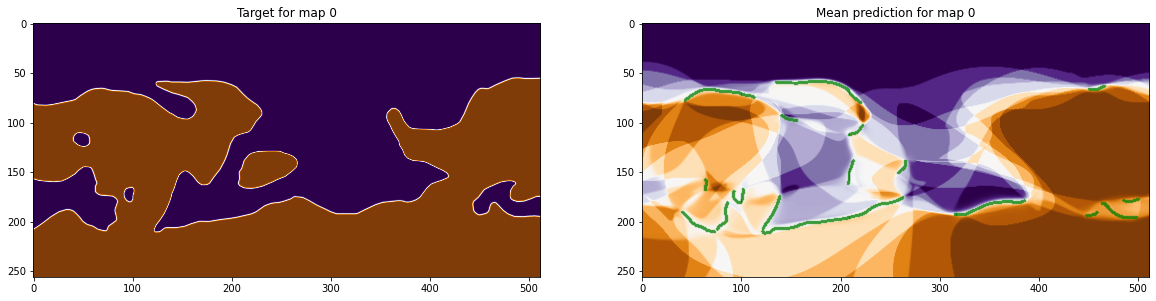

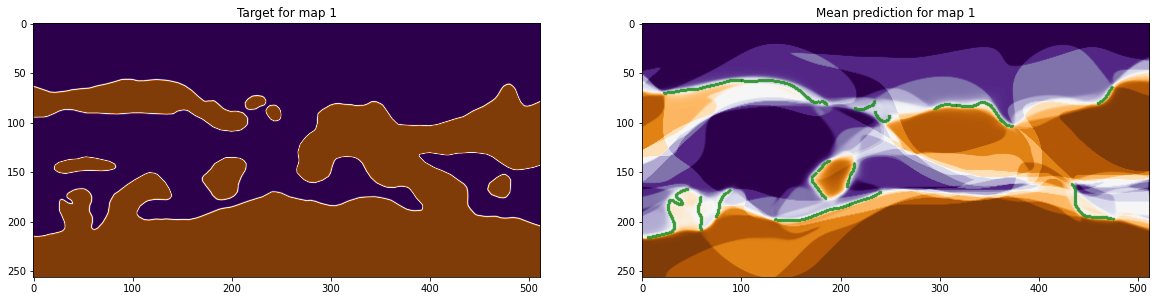

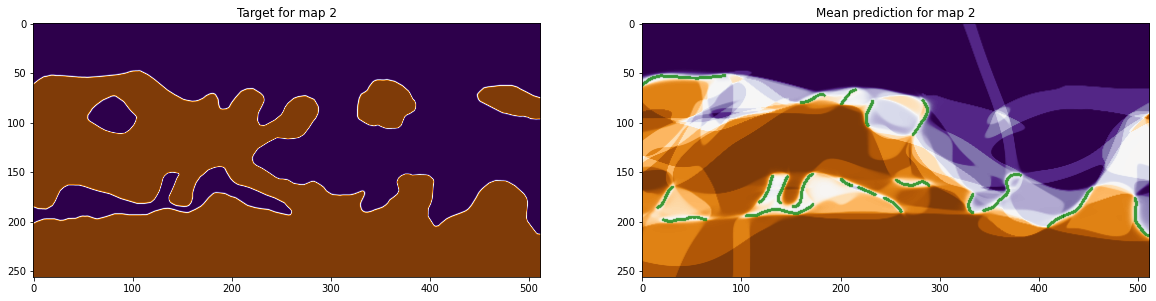

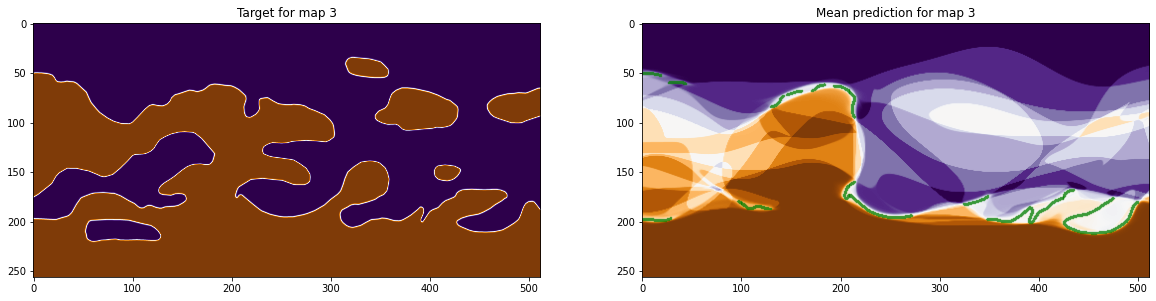

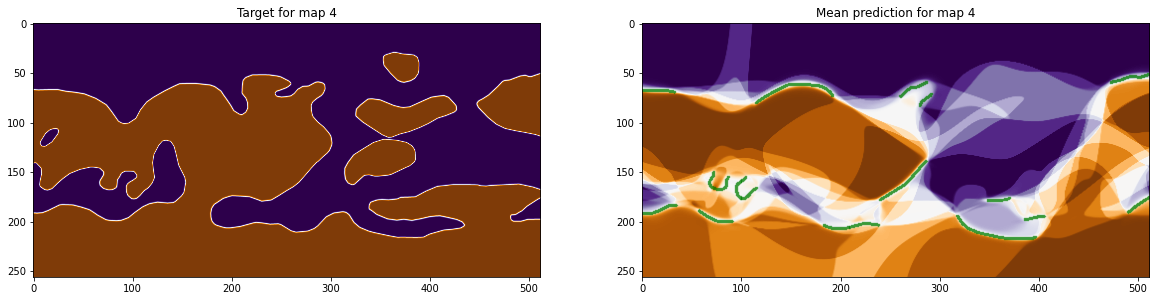

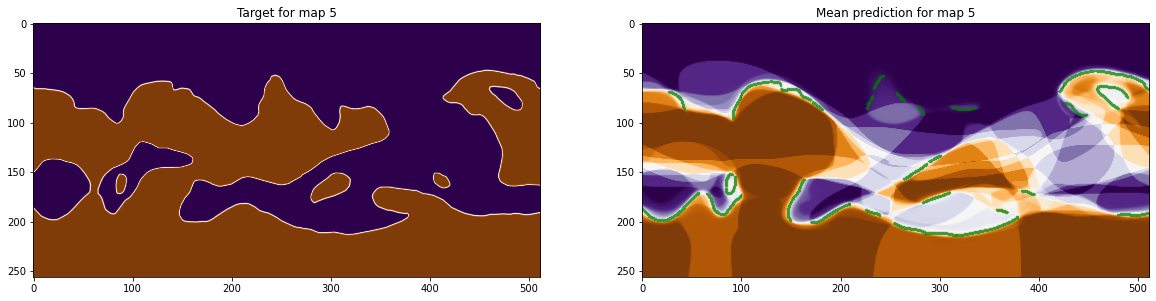

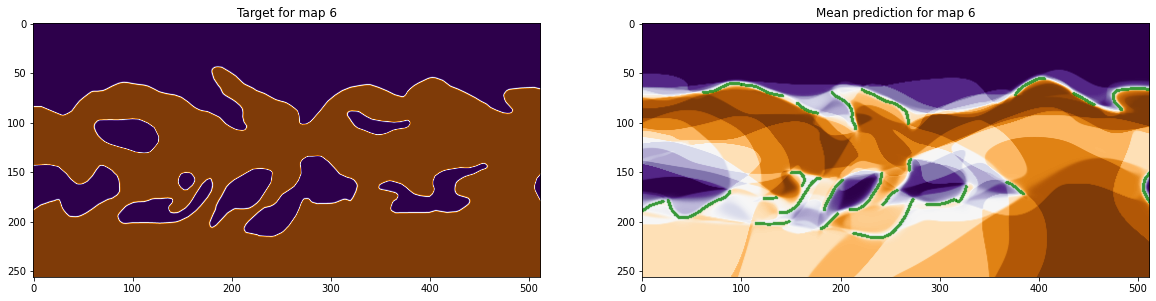

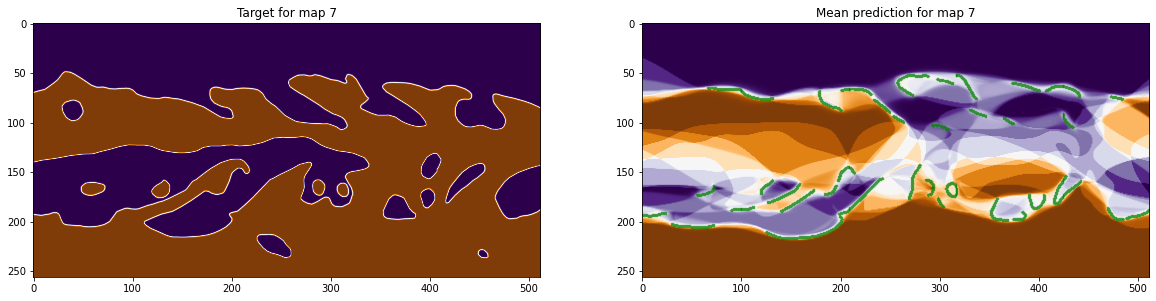

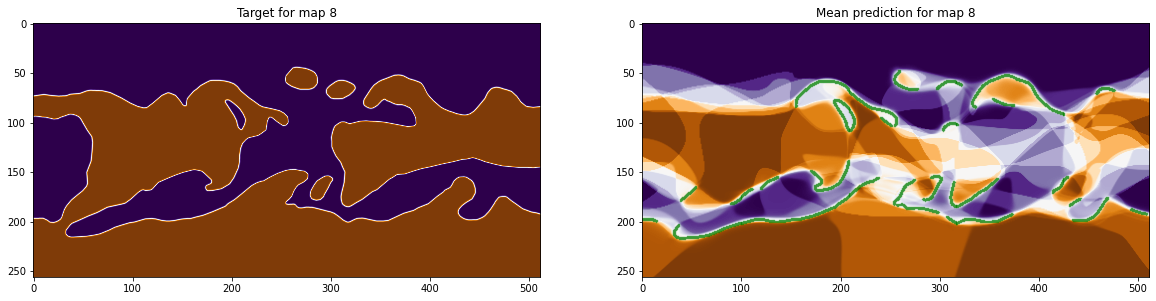

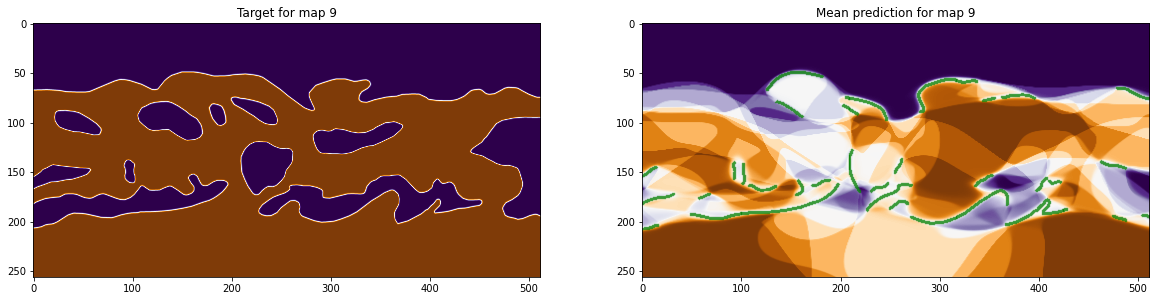

In [7]:
filenames = os.listdir(PATH_TO_MCINTOSH)[:10]
path_to_save = './Tests/Fits/Mean/step73/'
os.makedirs(path_to_save, exist_ok=True)

for i, filename in enumerate(filenames):
    predictions = []
    for n in tqdm(range(10), desc=f'Predicting map {i+1}/{len(filenames)}'):
        imgdata = ImageData(os.path.join(PATH_TO_MCINTOSH, filename), data_mode='fits')
        model = NeutralLiner(image_list=[imgdata],
                            lr=5e-3,
                            help_step_size=73,
                            mode='3d',
                            arch=[3, 6, 12, 24, 12, 6, 3, 1],
                            weight_decay=1e-4)
        model.to(device)
        model.start_training(num_epochs=30000, need_plot=False)
        prediction = model.test_model(need_plot=False,
                                      full_path_to_save=os.path.join(path_to_save, f'map_{i:02d}_{n}')
                                      )[0].view(model.image_list[0].img_array.shape).cpu().detach()
        predictions.append(prediction)
        model.save_state_dict(os.path.join(path_to_save, f'map_{i:02d}_{n}.pt'))
    predictions = torch.stack(predictions)
    prediction = torch.mean(predictions, dim=0)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(imgdata.target_img, cmap='PuOr')
    plt.title(f'Target for map {i}')
    plt.subplot(1, 2, 2)
    plt.imshow(prediction, cmap='PuOr')
    plt.title(f'Mean prediction for map {i}')
    x, y = np.where(imgdata.img_array < imgdata.img_array.max())
    plt.scatter(y, x, s=0.2, c='green', alpha=0.7)
    plt.savefig(os.path.join(path_to_save, f'map_{i:02d}_mean.png'), bbox_inches='tight', pad_inches=0, facecolor='white')

### no step

In [ ]:
filenames = os.listdir(PATH_TO_MCINTOSH)[:10]
path_to_save = './Tests/Fits/Mean/nostep'
os.makedirs(path_to_save, exist_ok=True)

for i, filename in enumerate(filenames):
    predictions = []
    for n in tqdm(range(10), desc=f'Predicting map {i+1}/{len(filenames)}'):
        imgdata = ImageData(os.path.join(PATH_TO_MCINTOSH, filename), data_mode='fits')
        model = NeutralLiner(image_list=[imgdata],
                            lr=5e-3,
                            help_step_size=None,
                            mode='3d',
                            arch=[3, 6, 12, 24, 12, 6, 3, 1],
                            weight_decay=1e-4)
        model.to(device)
        model.start_training(num_epochs=30000, need_plot=False)
        prediction = model.test_model(need_plot=False,
                                      full_path_to_save=os.path.join(path_to_save, f'map_{i:2d}_{n}')
                                      )[0].view(model.image_list[0].img_array.shape).cpu().detach()
        predictions.append(prediction)
        model.save_state_dict(os.path.join(path_to_save, f'map_{i:2d}_{n}.pt'))
    predictions = torch.stack(predictions)
    prediction = torch.mean(predictions, dim=0)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(imgdata.target_img, cmap='PuOr')
    plt.title(f'Target for map {i}')
    plt.subplot(1, 2, 2)
    plt.imshow(prediction, cmap='PuOr')
    plt.title(f'Mean prediction for map {i}')
    plt.savefig(os.path.join(path_to_save, f'map_{i:2d}_mean.png'), bbox_inches='tight', pad_inches=0, facecolor='white')

## 10 runs for 11-20 maps

### step 1 (full info)

In [8]:
filenames = os.listdir(PATH_TO_MCINTOSH)[10:20]
path_to_save = './Tests/Fits/Mean/11-20/step1'
os.makedirs(path_to_save, exist_ok=True)

for i, filename in enumerate(filenames):
    predictions = []
    for n in tqdm(range(10), desc=f'Predicting map {i+1}/{len(filenames)}'):
        imgdata = ImageData(os.path.join(PATH_TO_MCINTOSH, filename), data_mode='fits')
        model = NeutralLiner(image_list=[imgdata],
                            lr=5e-3,
                            help_step_size=32,
                            mode='3d',
                            arch=[3, 6, 12, 24, 12, 6, 3, 1],
                            weight_decay=1e-4)
        model.to(device)
        model.start_training(num_epochs=30000, need_plot=False)
        prediction = model.test_model(need_plot=False,
                                      full_path_to_save=os.path.join(path_to_save, f'map_{i:02d}_{n}')
                                      )[0].view(model.image_list[0].img_array.shape).cpu().detach()
        predictions.append(prediction)
        model.save_state_dict(os.path.join(path_to_save, f'map_{i:02d}_{n}.pt'))
    predictions = torch.stack(predictions)
    prediction = torch.mean(predictions, dim=0)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(imgdata.target_img, cmap='PuOr')
    plt.title(f'Target for map {i}')
    plt.subplot(1, 2, 2)
    plt.imshow(prediction, cmap='PuOr')
    plt.title(f'Mean prediction for map {i}')
    x, y = np.where(imgdata.img_array < imgdata.img_array.max())
    plt.scatter(y, x, s=0.2, c='green', alpha=0.5)
    plt.savefig(os.path.join(path_to_save, f'map_{i:02d}_mean.png'), bbox_inches='tight', pad_inches=0, facecolor='white')

Predicting map 6/10:  70%|███████   | 7/10 [1:13:49<32:02, 640.95s/it]

In [ ]:
def test_me():
    filenames = os.listdir(PATH_TO_MCINTOSH)
    path_to_save = './Tests/Fits/Mean/big/step1'
    os.makedirs(path_to_save, exist_ok=True)

    for i, filename in enumerate(filenames):
        predictions = []
        for n in tqdm(range(10), desc=f'Predicting map {i+1}/{len(filenames)}'):
            imgdata = ImageData(os.path.join(PATH_TO_MCINTOSH, filename), data_mode='fits')
            model = NeutralLiner(image_list=[imgdata],
                                lr=5e-3,
                                help_step_size=32,
                                mode='3d',
                                arch=[3, 6, 12, 24, 12, 6, 3, 1],
                                weight_decay=1e-4)
            model.to(device)
            model.start_training(num_epochs=30000, need_plot=False)
            prediction = model.test_model(need_plot=False,
                                        full_path_to_save=os.path.join(path_to_save, f'map_{i:02d}_{n}')
                                        )[0].view(model.image_list[0].img_array.shape).cpu().detach()
            predictions.append(prediction)
            model.save_state_dict(os.path.join(path_to_save, f'map_{i:02d}_{n}.pt'))
        predictions = torch.stack(predictions)
        prediction = torch.mean(predictions, dim=0)
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(imgdata.target_img, cmap='PuOr')
        plt.title(f'Target for map {i}')
        plt.subplot(1, 2, 2)
        plt.imshow(prediction, cmap='PuOr')
        plt.title(f'Mean prediction for map {i}')
        x, y = np.where(imgdata.img_array < imgdata.img_array.max())
        plt.scatter(y, x, s=0.2, c='green', alpha=0.5)
        plt.savefig(os.path.join(path_to_save, f'map_{i:02d}_mean.png'), bbox_inches='tight', pad_inches=0, facecolor='white')